**A supercar with rocket engines on two sides**

You are the driver of your awesome supercar on an infinitely long road, equipped with rocket engines on both the left and right sides. You can accelerate or decelerate the car, but remember that the power of your car is limited.

Given the initial position and velocity, your mission is simple : park your car at the origin (=make the position and velocity 0 simultaneously) and minimize the stopping time. Show your driving skills!

**Example 1.**

* We have a priori bang-bang assumption (i.e., your car is always at full power)
* We completely know the classical mechanics.
* We know how to minimize the stopping time by using the ad hoc geometric method.


Q1. Define the optimal thrust function whose inputs are the current position and velocity.

Q2. Employing that function, write the code that outputs the optimal stopping time and the corresponding trajectory. Discretize the time interval(=use a small time step dt<<<1)

Q3. Plot the velocity-position, position-time, velocity-time, and acceleration-time graphs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [2]:
def thrust(v, q):

    if v*abs(v) + 2*q > 0:
        acc = -1

    elif v*abs(v) + 2*q < 0:
        acc = 1

    elif v > 0:
        acc = -1

    elif v < 0:
        acc = 1
    
    else:
        acc = 0

    return acc


In [3]:
def analytic_sol(q, v, dt):
    q_list = [q]; v_list = [v]
    a_list = []
    idx = 0 
    while abs(q) > 0.01 or abs(v)>0.01:
        a = thrust(v, q)
        q_next = q + (2*v + a*dt)*dt/2
        v_next = v + a*dt
        q_list.append(q_next)
        v_list.append(v_next)
        a_list.append(a)
        idx += 1
        q = q_list[idx]; v = v_list[idx]

    return q_list, v_list, a_list, idx

**Question 1.**

* We have a priori bang-bang assumption.
* We completely know the classical mechanics.
* We **do not** know how to minimize the stopping time.
* Nevertheless, we know **machine learning**.

Q1. Define an appropriate class for modeling the car.

Q2. Set up the neural network and training environment. Provide only the bang-bang assumption to the computer!

Q3. Plot the result. Compare this to the previous (analytic) one.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [5]:
#------------Q1-------------

class CarEnvironment:

    def __init__(self):
        
        self.mass = 1.0
        self.thrust = 1.0
        self.dt = 0.1

        self.state = None
        self.steps = 0
        self.max_steps = 200

    def reset(self, specific_state = None):

        if specific_state is not None:

            self.state = np.array(specific_state, dtype=np.float32)
        
        else:
            self.state = np.array([np.random.uniform(-2,2), np.random.uniform(-1,1)], dtype=np.float32)

        self.steps = 0
        return self.state

    def step(self, action_idx):

        force = -self.thrust if action_idx == 0 else self.thrust

        x, v = self.state
        acc = force / self.mass

        v_next = v + acc * self.dt
        x_next = x + v * self.dt

        self.state = np.array([x_next,v_next], dtype=np.float32)
        self.steps += 1

        done = False
        target_reached = (abs(x_next) < 0.1) and (abs(v_next) < 0.1)

        reward = -0.1 #Time penalty

        if target_reached:
            reward = 10
            done = True

        elif abs(x_next) > 4:
            reward = -10
            done = True

        elif self.steps >= self.max_steps:
            done = True

        return self.state, reward, done

In [6]:
#------------Q2------------

class QNet(nn.Module):

    def __init__(self):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(2, 64) # input : state (q, v)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, 2) # output : action 0(-1) or 1(+1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  

def train_agent(epsisodes = 1000):
    env = CarEnvironment()
    model = QNet()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.MSELoss()

    epsilon = 1
    epsilon_decay = 0.995
    epsilon_min = 0.01
    gamma = 0.99

    replay_buffer = deque(maxlen = 2000) # 크기 2000짜리 배열, 선입선출
    batch_size = 32

    print("Training Started...")
    for e in range(epsisodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:

            if random.random() < epsilon:
                action = random.choice([0, 1])

            else:
                with torch.no_grad():
                    q_values = model(torch.FloatTensor(state))
                    action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(replay_buffer) > batch_size:
                minibatch = random.sample(replay_buffer, batch_size)

                states_b = torch.FloatTensor(np.array([m[0] for m in minibatch]))
                actions_b = torch.LongTensor(np.array([m[1] for m in minibatch])).unsqueeze(1)
                rewards_b = torch.FloatTensor(np.array([m[2] for m in minibatch]))
                next_states_b = torch.FloatTensor(np.array([m[3] for m in minibatch]))
                dones_b = torch.FloatTensor(np.array([m[4] for m in minibatch]))

                current_q = model(states_b).gather(1, actions_b).squeeze(1)
                max_next_q = model(next_states_b).max(1)[0]
                target_q = rewards_b + (gamma*max_next_q*(1-dones_b))

                loss = criterion(current_q, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if (e+1)%100 == 0:
            print(f"Episode {e+1}/{epsisodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return model


In [11]:
trained_model = train_agent(epsisodes=2000)

Training Started...
Episode 100/2000, Total Reward: -20.00, Epsilon: 0.61
Episode 200/2000, Total Reward: 6.90, Epsilon: 0.37
Episode 300/2000, Total Reward: 8.30, Epsilon: 0.22
Episode 400/2000, Total Reward: 7.80, Epsilon: 0.13
Episode 500/2000, Total Reward: 9.90, Epsilon: 0.08
Episode 600/2000, Total Reward: 6.70, Epsilon: 0.05
Episode 700/2000, Total Reward: 8.80, Epsilon: 0.03
Episode 800/2000, Total Reward: 7.00, Epsilon: 0.02
Episode 900/2000, Total Reward: 6.10, Epsilon: 0.01
Episode 1000/2000, Total Reward: 8.20, Epsilon: 0.01
Episode 1100/2000, Total Reward: 8.40, Epsilon: 0.01
Episode 1200/2000, Total Reward: -11.50, Epsilon: 0.01
Episode 1300/2000, Total Reward: 9.30, Epsilon: 0.01
Episode 1400/2000, Total Reward: 8.50, Epsilon: 0.01
Episode 1500/2000, Total Reward: 8.80, Epsilon: 0.01
Episode 1600/2000, Total Reward: 6.70, Epsilon: 0.01
Episode 1700/2000, Total Reward: 7.00, Epsilon: 0.01
Episode 1800/2000, Total Reward: 8.40, Epsilon: 0.01
Episode 1900/2000, Total Reward

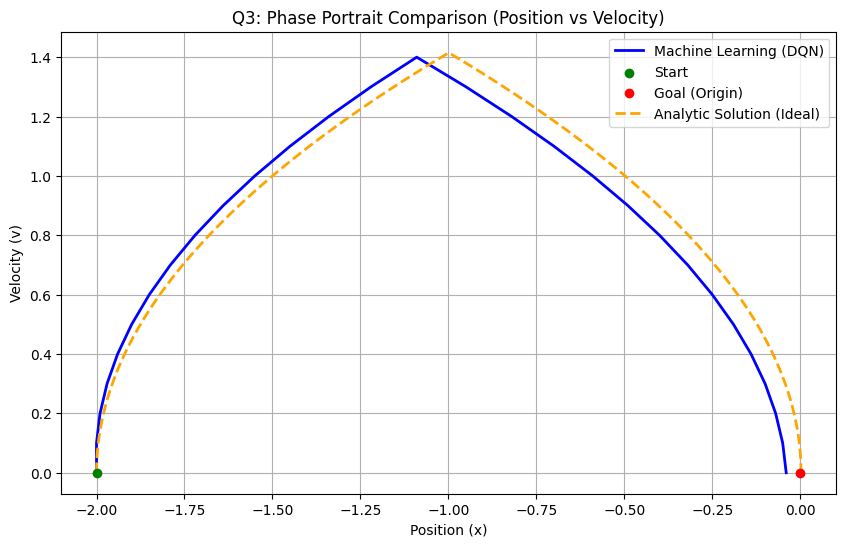

In [12]:
def plot_results(model):
    env = CarEnvironment()
    # 비교를 위해 고정된 시작 상태 설정 (예: 위치 -2, 속도 0에서 시작)
    start_state = [-2.0, 0.0]
    state = env.reset(specific_state=start_state)
    dt = 0.001
    
    # 1. 머신러닝(RL) 결과 기록
    ml_x, ml_v = [state[0]], [state[1]]
    done = False
    while not done:
        with torch.no_grad():
            q_values = model(torch.FloatTensor(state))
            action = torch.argmax(q_values).item()
        state, _, done = env.step(action)
        ml_x.append(state[0])
        ml_v.append(state[1])

    # 2. 해석적(Analytic) 결과 계산
    [ana_x, ana_v, bangbang, step] = analytic_sol(start_state[0], start_state[1], dt)

    # 3. 플롯 그리기 (Phase Portrait: 위치 vs 속도)
    plt.figure(figsize=(10, 6))
    
    # ML Trajectory
    plt.plot(ml_x, ml_v, label='Machine Learning (DQN)', color='blue', linewidth=2)
    plt.scatter([ml_x[0]], [ml_v[0]], color='green', label='Start', zorder=5)
    plt.scatter([0], [0], color='red', label='Goal (Origin)', zorder=5)
    
    # Analytic Trajectory
    plt.plot(ana_x, ana_v, label='Analytic Solution (Ideal)', color='orange', linestyle='--', linewidth=2)
    
    plt.title("Q3: Phase Portrait Comparison (Position vs Velocity)")
    plt.xlabel("Position (x)")
    plt.ylabel("Velocity (v)")
    plt.grid(True)
    plt.legend()
    plt.show()

# 결과 시각화
plot_results(trained_model)

In [ ]:
[ana_x, ana_v, bangbang, step] = analytic_sol(-2 , 0, 0.1)

print(ana_v[-1])

-2.7755575615628914e-17


# 